# Computing Meridional Overturning

In [1]:
# Don't display filter warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import xarray as xr
import os
import fastjmd95 as jmd95

from dask.diagnostics import ProgressBar

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys
sys.path.append('../scripts')
from preprocessing import preprocessing

In [3]:
mod = 'CM4' # CM4, ESM4
exp = 'antwaterstress' # control, antwater, stress, antwaterstress
mem = 251 # 251, 290, 332 (CM4) / 101, 151, 201 (ESM4)

In [4]:
outdir='/scratch/gpfs/jt7058/GFDL/fafmip/netcdf/'
rootdir = '/scratch/gpfs/jt7058/GFDL/fafmip/raw/'
if mod=='CM4':
    subdir = 'CM4_piControl_C'
elif mod=='ESM4':
    subdir = 'ESM4_piControl_D'
pp = 'ocean_annual_rho2'
fafdir = '%s_faf%s_%s'%(subdir,exp,str(mem) if mod=='CM4' else str(mem))
full_path = os.path.join(rootdir,subdir,pp) if exp=='control' else os.path.join(rootdir,fafdir,pp)
head = '%s_%s'%(mod,exp) if exp=='control' else '%s_%s_%s'%(mod,exp,str(mem))
print(head+':',full_path)

CM4_antwaterstress_251: /scratch/gpfs/jt7058/GFDL/fafmip/raw/CM4_piControl_C_fafantwaterstress_251/ocean_annual_rho2


In [5]:
ds = xr.open_mfdataset(full_path+'/'+pp+'.*.*.nc',use_cftime=True, 
                       drop_variables=['average_DT','average_T1','average_T2'])

In [6]:
print(ds.dims)

Frozen({'nv': 2, 'rho2_i': 36, 'rho2_l': 35, 'time': 100, 'yq': 1080, 'xh': 1440, 'yh': 1080})


In [7]:
pp = 'ocean_monthly'

if subdir[:3] == 'CM4':
    grid = xr.open_dataset(rootdir+'CM4_piControl_C/'+pp+'/'+pp+'.static.nc')
elif subdir[:3] == 'ESM':
    grid = xr.open_dataset(rootdir+'ESM4_piControl_D/'+pp+'/'+pp+'.static.nc')
else:
    print('grid is not available for '+subdir)

In [8]:
rho0 = 1035.0
contours = [-30,-26,-22,-18,-14,-10,-6,-2,2,6,10,14,18,22,26,30]
#contours = np.concatenate([np.arange(-25,0,5),np.array([-2,2]),np.arange(5,30,5)])

### Global MOC

In [9]:
rho2_i = ds.rho2_i

In [10]:
ds = preprocessing(ds, grid, decode_times=False, verbose=False)

In [11]:
print(str(ds.time.values[0])[:10],'to',str(ds.time.values[-1])[:10])

0001-07-02 to 0100-07-02


In [12]:
vmo = ds.vmo.where(ds.vmo<1e14)

In [13]:
with ProgressBar():
    moc_rho2 = vmo.sum('x').cumsum('rho2_l').load()

[########################################] | 100% Completed | 45.2s


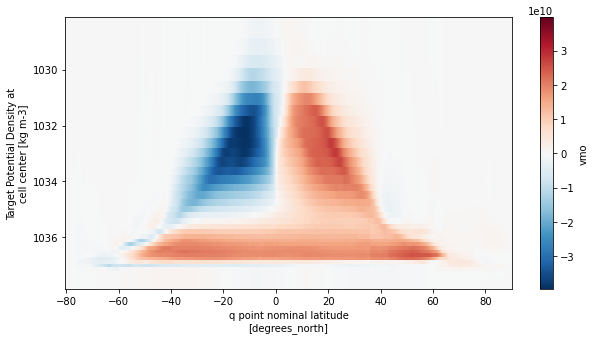

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
moc_rho2.mean('time').sel(rho2_l=slice(1028.5,None)).plot(ax=ax, yincrease=False,cmap='RdBu_r')

In [13]:
# Sum over the zonal direction and integrate along density
integ_layers = (vmo.sum('x').cumsum('rho2_l') - vmo.sum('x').sum('rho2_l'))/rho0/1.0e6 + 0.1

# The result of the integration over layers is evaluated at the interfaces
# with psi = 0 as the bottom boundary condition for the integration
bottom_condition = xr.zeros_like(integ_layers.isel({'rho2_l': 0}))

# combine bottom condition with data array
#psi_raw = xr.concat([integ_layers, bottom_condition], dim='rho2_l')
psi_raw = xr.concat([bottom_condition, integ_layers], dim='rho2_l')

# need to rechunk to new size
psi_raw = psi_raw.chunk({'rho2_l': len(psi_raw['rho2_l'])})

# rename to correct dimension and add correct vertical coordinate
psi = psi_raw.rename({'rho2_l': 'rho2_i'}).transpose('time','rho2_i','yq')
psi['rho2_i'] = rho2_i
psi.name = 'psi'

In [16]:
with ProgressBar():
    moc_rho2 = psi.load()

[########################################] | 100% Completed | 11.2s


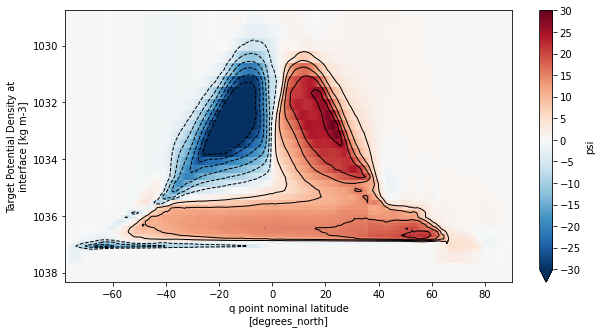

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
moc_rho2.mean('time').sel(rho2_i=slice(1028.5,None))\
        .plot(ax=ax, yincrease=False,vmin=-30,vmax=30,cmap='RdBu_r',
              cbar_kwargs={'ticks': np.arange(-30,35,5)})
moc_rho2.mean('time').sel(rho2_i=slice(1028.5,None))\
        .plot.contour(ax=ax, yincrease=False, levels=np.concatenate([np.arange(-30,0,5),np.arange(5,35,5)]), 
                      colors='k', linewidths=1)
plt.show()

In [17]:
var = 'moc'
fname = head+'_global_%sto%s_%s_rho2_online_lores.nc'\
        %(str(ds.time.dt.year[0].values).rjust(4, '0'),
          str(ds.time.dt.year[-1].values).rjust(4, '0'), var)
print('Saving to file:', fname)
moc_rho2.reset_coords(drop=True).to_dataset(name='psi').to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: ESM4_control_global_0101to0270_moc_rho2_online_lores.nc


### Subselect Southern Ocean

In [18]:
tstr = '%sto%s'%(str(ds.time.dt.year[0].values).rjust(4, '0'),str(ds.time.dt.year[-1].values).rjust(4, '0'))
moc_rho2 = xr.open_dataset(outdir+head+'_global_'+tstr+'_moc_rho2_online_lores.nc').psi

In [19]:
smoc_rho2 = moc_rho2.sel(rho2_i=slice(1033,1038),yq=slice(None,0))

In [20]:
if mod=='CM4':
    if exp=='control':
        yr_st,yr_ed = '0281','0380'
    else:
        yr_st,yr_ed = '0051','0070'
elif mod=='ESM4':
    if exp=='control':
        yr_st,yr_ed = '0121','0220'
    elif mem==101:
        yr_st,yr_ed = '0151','0170'
    else:
        yr_st,yr_ed = '0051','0070'

print('Calculate mean over years',yr_st,yr_ed)
smoc_rho2_mean = smoc_rho2.sel(time=slice(yr_st,yr_ed)).mean('time')

Calculate mean over years 0121 0220


In [21]:
smoc_rho2_mean['sigma2'] = smoc_rho2_mean.rho2_i-1000
smoc_rho2_mean = smoc_rho2_mean.swap_dims({'rho2_i':'sigma2'})

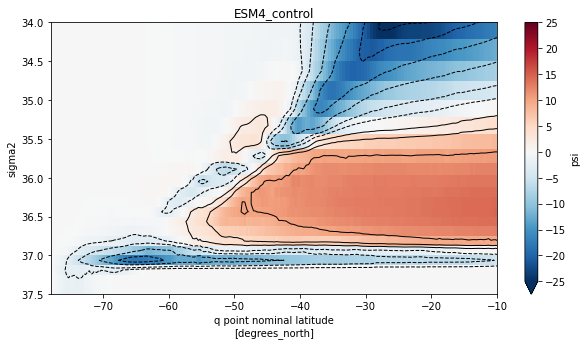

In [22]:
fig, ax = plt.subplots(figsize=(10,5))
smoc_rho2_mean.plot(ax=ax, yincrease=False,vmin=-25,vmax=25,cmap='RdBu_r',
                    cbar_kwargs={'ticks': np.arange(-25,30,5)})
smoc_rho2_mean.plot.contour(ax=ax, yincrease=False, levels=contours, 
                            colors='k', linewidths=1)
ax.set_xlim((-78,-10))
ax.set_ylim((37.5,34))
ax.set_title(head)
plt.show()

In [23]:
# Find the location of the minimum (lower limb overturning)
smoc_lower_mean = smoc_rho2_mean.sel(sigma2=slice(36.5,None),yq=slice(None,-30))
y_min_idx = smoc_lower_mean.argmin(dim=['sigma2', 'yq'])['yq']
rho2_min_idx = smoc_lower_mean.argmin(dim=['sigma2', 'yq'])['sigma2']

In [24]:
print('Minimum:',
      np.round(smoc_lower_mean.isel(sigma2=rho2_min_idx,yq=y_min_idx).values,1),'Sv at',
      np.round(smoc_lower_mean.yq[y_min_idx].values,1),'N and',
      np.round(smoc_lower_mean.sigma2[rho2_min_idx].values,1),'kg/m^3 density')

Minimum: -18.2 Sv at -65.1 N and 37.1 kg/m^3 density


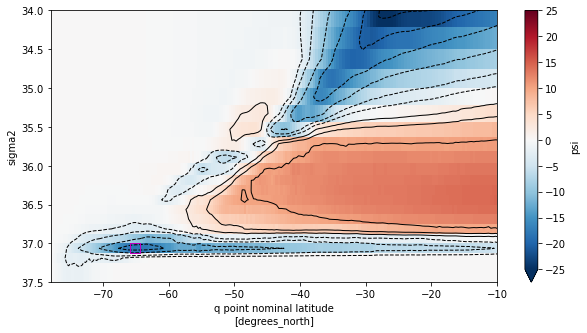

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
smoc_rho2_mean.plot(ax=ax, yincrease=False,vmin=-25,vmax=25,cmap='RdBu_r',
                    cbar_kwargs={'ticks': np.arange(-25,30,5)})
smoc_rho2_mean.plot.contour(ax=ax, yincrease=False, levels=contours, 
                            colors='k', linewidths=1)
ax.plot(smoc_lower_mean.yq[y_min_idx],smoc_lower_mean.sigma2[rho2_min_idx],
        marker='s',c='m',ms=10,mew=1,mfc='none')
ax.set_xlim((-78,-10))
ax.set_ylim((37.5,34))
plt.show()

In [26]:
smoc_rho2_lower = smoc_rho2.sel(rho2_i=slice(1036.5,None),yq=slice(None,-30))

In [27]:
smoc_rho2_lower_dec = smoc_rho2_lower.resample({'time':'10A'},loffset='4A').mean()

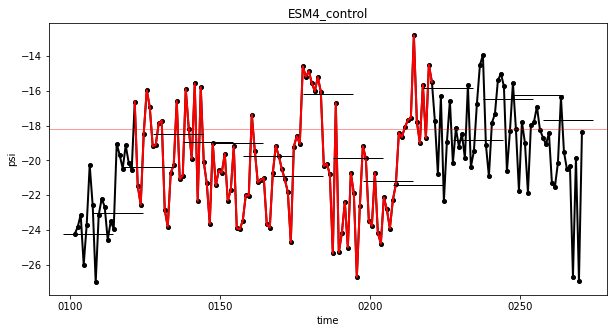

In [28]:
fig, ax = plt.subplots(figsize=(10,5))
smoc_rho2_lower.min(dim=['rho2_i', 'yq']).plot(ax=ax,lw=2,c='k',marker='o',ms=4)
smoc_rho2_lower.min(dim=['rho2_i', 'yq']).sel(time=slice(yr_st,yr_ed)).plot(ax=ax,lw=2,c='r')
smoc_rho2_lower_dec.min(dim=['rho2_i', 'yq']).isel(time=slice(None,-1))\
    .plot(ax=ax,ls='None',c='k',marker='_',ms=50)
ax.axhline(y=np.round(smoc_lower_mean.isel(sigma2=rho2_min_idx,yq=y_min_idx).values,1), xmin=0, xmax=1, 
               linewidth=1.0, color = 'r',alpha=0.4)
ax.set_title(head)
plt.show()

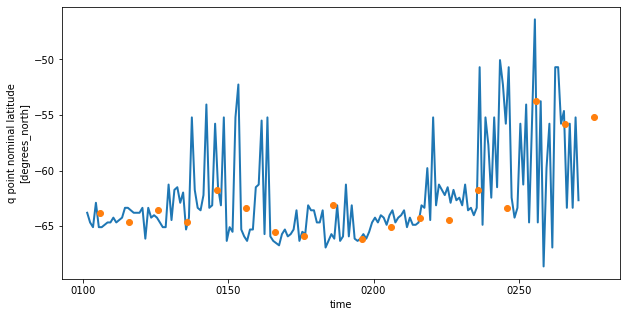

In [29]:
fig, ax = plt.subplots(figsize=(10,5))
smoc_rho2_lower.yq[smoc_rho2_lower.argmin(dim=['rho2_i', 'yq'])['yq']].plot(ax=ax,lw=2)
smoc_rho2_lower_dec.yq[smoc_rho2_lower_dec.argmin(dim=['rho2_i', 'yq'])['yq']].plot(ax=ax,ls='None',marker='o')

### Calculate `sigma2` in z space

In [14]:
from compute import get_xgcm_grid

In [16]:
zarr_path = os.path.join(outdir[:-7],'zarr',mod,exp,'annual') if exp=='control'\
            else os.path.join(outdir[:-7],'zarr',mod,exp,str(mem),'annual')
print(zarr_path)
ds_z = xr.open_zarr(zarr_path)

/scratch/gpfs/jt7058/GFDL/fafmip/zarr/CM4/antwaterstress/251/annual


In [18]:
ds_z = preprocessing(ds_z,grid, decode_times=False, verbose=False)

In [19]:
xgrid = get_xgcm_grid(ds_z,grid.rename({'xh':'x','yh':'y'}),periodic=['X'])

In [20]:
sig = xgrid.interp(jmd95.rho(ds_z.so, ds_z.thetao, 2000) - 1000, 'Y', boundary='extend').rename('sigma2')

In [21]:
if mod=='CM4':
    if exp=='control':
        sig = sig.sel(time=slice('0281','0380'))
    else:
        sig = sig.sel(time=slice('0051','0070'))

elif mod=='ESM4':
    if exp=='control':
        sig = sig.sel(time=slice('0121','0220'))
    elif mem==101:
        sig = sig.sel(time=slice('0151','0170'))
    else:
        sig = sig.sel(time=slice('0051','0070'))

In [37]:
with ProgressBar():
    sig2_mean = sig.mean('time').mean('x').load()

[########################################] | 100% Completed | 15.1s


In [38]:
fname = '%s_%s_%s_global_%sto%s_sigma2_jmd95_zmean.nc'\
        %(mod,exp,str(mem),str(sig.time.dt.year[0].values).rjust(4, '0'),
          str(sig.time.dt.year[-1].values).rjust(4, '0'))
print('Saving to file:', fname)
sig2_mean.reset_coords(drop=True).to_dataset(name='sigma2').to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: ESM4_antwaterstress_201_global_0051to0070_sigma2_jmd95_zmean.nc


### Reproject `rho2` overturning to z coordinates

In [22]:
if mod=='CM4':
    if exp=='control':
        volcello = ds.volcello.sel(time=slice('0281','0380'))
    else:
        volcello = ds.volcello.sel(time=slice('0051','0070'))

elif mod=='ESM4':
    if exp=='control':
        volcello = ds.volcello.sel(time=slice('0121','0220'))
    elif mem==101:
        volcello = ds.volcello.sel(time=slice('0151','0170'))
    else:
        volcello = ds.volcello.sel(time=slice('0051','0070'))

In [23]:
# Thickness mapped to rho2 
thk = (volcello/ds.areacello).mean('time')
#thk = ds.thkcello.mean('time')

# Cumulative sum of thickness to get the time averaged depth of an isopycnal 
#zrho = thk.mean('x').cumsum('rho2_l')
integ_layers = thk.mean('x').cumsum('rho2_l')
bottom_condition = xr.zeros_like(integ_layers.isel({'rho2_l': 0}))
zrho_raw = xr.concat([bottom_condition, integ_layers], dim='rho2_l') # preferred
zrho_raw = zrho_raw.chunk({'rho2_l': len(zrho_raw['rho2_l'])})
zrho = zrho_raw.rename({'rho2_l': 'rho2_i'}).transpose('rho2_i','y')

zrho['rho2_i'] = rho2_i
zrho.name = 'Depth'

In [24]:
tstr = '%sto%s'%(str(ds.time.dt.year[0].values).rjust(4, '0'),str(ds.time.dt.year[-1].values).rjust(4, '0'))
moc_rho2 = xr.open_dataset(outdir+head+'_global_'+tstr+'_moc_rho2_online_lores.nc').psi

if mod=='CM4':
    if exp=='control':
        psi = moc_rho2.sel(time=slice('0281','0380'))
    else:
        psi = moc_rho2.sel(time=slice('0051','0070'))

elif mod=='ESM4':
    if exp=='control':
        psi = moc_rho2.sel(time=slice('0121','0220'))
    elif mem==101:
        psi = moc_rho2.sel(time=slice('0151','0170'))
    else:
        psi = moc_rho2.sel(time=slice('0051','0070'))

In [25]:
psi.coords['depth'] = xgrid.interp(zrho, 'Y', boundary='extend')

In [26]:
with ProgressBar():
    psi_mean = psi.mean('time').load()

[########################################] | 100% Completed | 13.6s


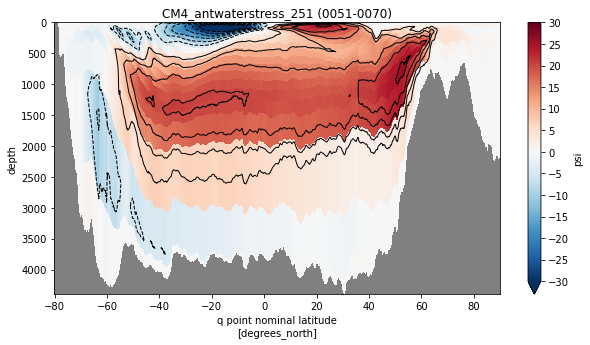

In [27]:
fig, ax = plt.subplots(figsize=(10,5))
psi_mean.plot(ax=ax,x='yq', y='depth',yincrease=False,vmin=-30,vmax=30,cmap='RdBu_r',
              cbar_kwargs={'ticks': np.arange(-30,35,5)})
psi_mean.plot.contour(ax=ax, x='yq', y='depth', yincrease=False, 
                      levels=np.concatenate([np.arange(-30,0,5),np.arange(5,35,5)]), 
                      colors='k', linewidths=1)
ax.set_facecolor('gray')
ax.set_title(head+' (%s-%s)'%(str(psi.time.dt.year[0].values).rjust(4, '0'),
                              str(psi.time.dt.year[-1].values).rjust(4, '0')))
ax.set_ylim((4400,0))
plt.show()

In [28]:
fname = head+'_global_%sto%s_moc_rho2_online_mean_lores_reprojected.nc'\
        %(str(psi.time.dt.year[0].values).rjust(4, '0'),
          str(psi.time.dt.year[-1].values).rjust(4, '0'))
print('Saving to file:', fname)
psi_mean.to_dataset(name='psi').to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: CM4_antwaterstress_251_global_0051to0070_moc_rho2_online_mean_lores_reprojected.nc


In [29]:
sig2_mean = xr.open_dataset(outdir+head+'_global_%sto%s_sigma2_jmd95_zmean.nc'\
                            %(str(psi.time.dt.year[0].values).rjust(4, '0'),
                              str(psi.time.dt.year[-1].values).rjust(4, '0'))).sigma2

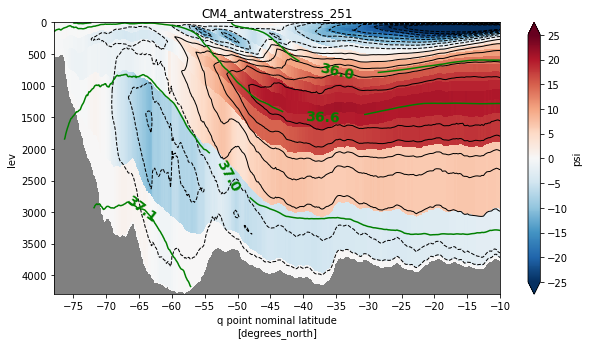

In [30]:
fig, ax = plt.subplots(figsize=(10,5))

psi_mean.plot(ax=ax,x='yq', y='depth', yincrease=False,vmin=-25,vmax=25,cmap='RdBu_r',
              cbar_kwargs={'ticks': np.arange(-25,30,5)})
psi_mean.plot.contour(ax=ax,x='yq', y='depth', yincrease=False, levels=contours, 
                      colors='k', linewidths=1)
cs = sig2_mean.plot.contour(ax=ax, x='yq', y='lev',yincrease=False,colors='g',lw=2,levels=[36.0,36.6,37.0])
clab = ax.clabel(cs, cs.levels, inline=True, fmt='%1.1f', fontsize=14,
                 manual=[(-35,800), (-37,1500), (-53,2500)],inline_spacing=1)
[txt.set_fontweight('bold') for txt in clab]
cs2 = sig2_mean.sel(yq=slice(-72,-57)).plot.contour(ax=ax, x='yq', y='lev',yincrease=False,colors='g',
                                                    lw=2,levels=[37.1])
clab2 = ax.clabel(cs2, cs2.levels, inline=False, fmt='%1.1f', fontsize=14, manual=[(-65,3000)])
[txt.set_fontweight('bold') for txt in clab2]
ax.set_xlim((-78,-10))
ax.set_facecolor('gray')
ax.set_xticks(np.arange(-75,-5,5))
ax.set_ylim((4300,0))
ax.set_title(head)
plt.show()

#### 1-by-2 plot

In [47]:
ddict = {mod:{} for mod in ['CM4','ESM4']}

for mod in ddict:
    dset = '_control_global_0281to0380_' if mod=='CM4' else '_control_global_0121to0220_'
    ddict[mod]['psiz'] = xr.open_dataset(outdir+mod+dset+'moc_rho2_online_mean_lores_reprojected.nc').psi
    ddict[mod]['sig2'] = xr.open_dataset(outdir+mod+dset+'sigma2_jmd95_zmean.nc').sigma2

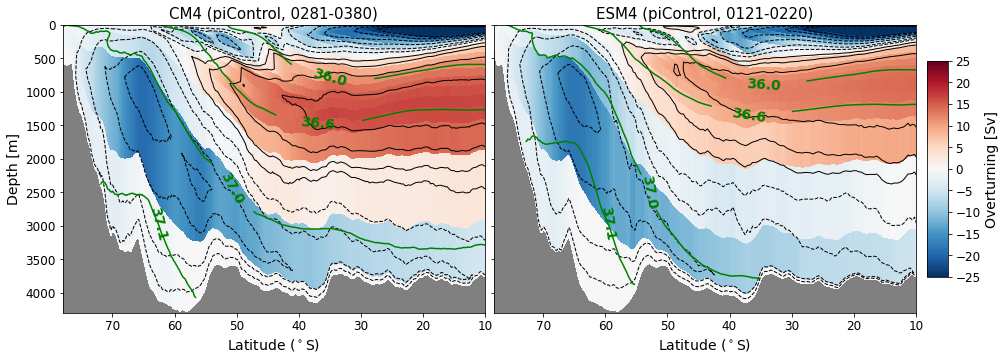

In [62]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15,5))
fig.subplots_adjust(left=0.1, right=0.89, bottom=0.1, top=0.9, hspace=0.2, wspace=0.02)

for i, mod in enumerate(ddict):
    
    p = ddict[mod]['psiz'].plot(ax=axs[i],x='yq', y='depth', yincrease=False,vmin=-25,vmax=25,cmap='RdBu_r',
                                add_colorbar=False, add_labels=False)
    ddict[mod]['psiz'].plot.contour(ax=axs[i],x='yq', y='depth', yincrease=False, levels=contours, 
                                    colors='k', linewidths=1, add_labels=False)
    
    cs = ddict[mod]['sig2'].plot.contour(ax=axs[i], x='yq', y='lev',yincrease=False,colors='g',lw=2,
                                         levels=[36.0,36.6], add_labels=False)
    clab = axs[i].clabel(cs, cs.levels, inline=True, fmt='%1.1f', fontsize=14,
                         manual=[(-35,800), (-37,1500)],inline_spacing=1)
    [txt.set_fontweight('bold') for txt in clab]
    
    if mod=='CM4':
        cs1 = ddict[mod]['sig2'].plot.contour(ax=axs[i], x='yq', y='lev',yincrease=False,colors='g',lw=2,
                                             levels=[37.0], add_labels=False)
        cs2 = ddict[mod]['sig2'].sel(yq=slice(-72,-56.5)).plot.contour(ax=axs[i], x='yq', y='lev',yincrease=False,
                                                                     colors='g',lw=2,levels=[37.1], add_labels=False)
    else:
        cs1 = ddict[mod]['sig2'].sel(yq=slice(None,-35)).plot.contour(ax=axs[i], x='yq', y='lev',yincrease=False,
                                                                      colors='g',lw=2,levels=[37.0], add_labels=False)
        cs2 = ddict[mod]['sig2'].sel(yq=slice(-73,-55)).plot.contour(ax=axs[i], x='yq', y='lev',yincrease=False,
                                                                     colors='g',lw=2,levels=[37.1], add_labels=False)
        
    clab1 = axs[i].clabel(cs1, cs1.levels, inline=True, fmt='%1.1f', fontsize=14,
                          manual=[(-53,2500)],inline_spacing=1)
    [txt.set_fontweight('bold') for txt in clab1]
    clab2 = axs[i].clabel(cs2, cs2.levels, inline=False, fmt='%1.1f', fontsize=14, manual=[(-65,3000)])
    [txt.set_fontweight('bold') for txt in clab2]
    axs[i].set_xlim((-78,-10))
    axs[i].set_ylim((4300,0))
    axs[i].set_xticks(np.arange(-70,0,10))
    axs[i].set_xticklabels(np.arange(70,0,-10))
    axs[i].set_xlabel('Latitude ($^\circ$S)',fontsize=14)
    axs[i].tick_params(axis='both', which='both', labelsize=12)
    axs[i].set_facecolor('gray')

axs[0].set_title('CM4 (piControl, 0281-0380)',fontsize=15)
axs[1].set_title('ESM4 (piControl, 0121-0220)',fontsize=15)
axs[0].set_ylabel(r'Depth [m]',fontsize=14)

cax = fig.add_axes([0.9, 0.2, 0.02, 0.60])
cb = fig.colorbar(p, cax=cax, ticks=np.arange(-25,30,5), orientation='vertical', shrink=0.9, pad=0.02)
cb.set_label(r'Overturning [Sv]', fontsize=14)
cb.ax.tick_params(labelsize=12)

plt.show()

## Overturning in z space

In [9]:
zarrdir = '/scratch/gpfs/jt7058/GFDL/fafmip/zarr/'
vars_ds = xr.open_zarr(os.path.join(zarrdir,mod,exp,'annual'))

In [10]:
vars_rho2_ds = xr.open_mfdataset(full_path+'/ocean_annual_rho2.*.*.nc',use_cftime=True, 
                                 drop_variables=['average_DT','average_T1','average_T2'])

In [13]:
ds_z = preprocessing(vars_ds, grid, decode_times=False, verbose=False)

In [14]:
vmo = ds_z.vmo.where(ds_z.vmo<1e14)

# Sum over the zonal direction and integrate from bottom
integ_layers = vmo.sum('x').reindex(lev=vmo.lev[::-1]).cumsum('lev') # Reverse vertical (density) axis and integrate
#integ_layers = vmo.sum('x').cumsum('lev') - vmo.sum('x').sum('lev')

# The result of the integration over layers is evaluated at the interfaces
# with psi = 0 as the bottom boundary condition for the integration
bottom_condition = xr.zeros_like(integ_layers.isel({'lev': 0}))

# combine bottom condition with data array
#psi_raw = xr.concat([bottom_condition, integ_layers], dim='lev')
psi_raw = xr.concat([integ_layers.reindex(lev=integ_layers.lev[::-1]),bottom_condition], dim='lev')

# need to rechunk to new size
psi_raw = psi_raw.chunk({'lev': len(psi_raw['lev'])})

# rename to correct dimension and add correct vertical coordinate
psi = -psi_raw.rename({'lev': 'lev_outer'}).transpose('time','lev_outer','yq')
psi['lev_outer'] = ds_z.lev_outer
psi.name = 'psi'

# Convert kg.s-1 to Sv (1e6 m3.s-1)
moc = psi / rho0 / 1.0e6

In [15]:
with ProgressBar():
    moc_z = moc.load()

[########################################] | 100% Completed | 27.7s


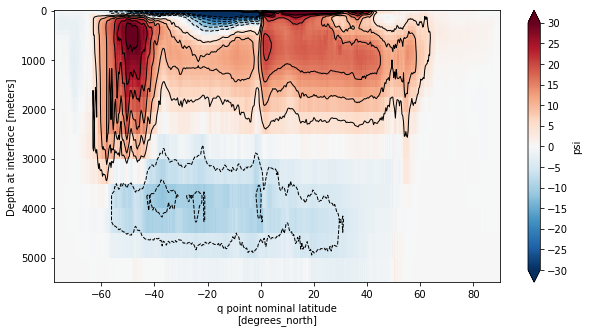

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
moc_z.mean('time').sel(lev_outer=slice(None,5500)).plot(ax=ax, yincrease=False,vmin=-30,vmax=30,cmap='RdBu_r',
                                                       cbar_kwargs={'ticks': np.arange(-30,35,5)})
moc_z.mean('time').sel(lev_outer=slice(None,5500)).plot.contour(ax=ax, yincrease=False, colors='k', linewidths=1,
                                                                levels=np.concatenate([np.arange(-30,0,5),
                                                                                       np.arange(5,35,5)]))
                     
plt.show()

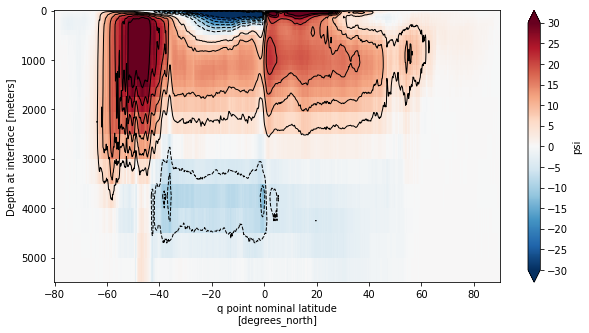

In [17]:
var = 'moc'
fname = '%s_%s_global_%sto%s_%s_z.nc'\
        %(mod,exp,str(ds.time.dt.year[0].values).rjust(4, '0'),str(ds.time.dt.year[-1].values).rjust(4, '0'), var)
print('Saving to file:', fname)
moc_z.reset_coords(drop=True).to_dataset(name='psi').to_netcdf(outdir+fname, format='NETCDF4')

Saving to file: ESM4_control_global_0101to0300_moc_z.nc


### Separate by basin

In [ ]:
from xoverturning import calcmoc

In [32]:
# atlantic
amoc_z = calcmoc(vars_ds, dsgrid=grid, basin='atl-arc')

generating basin codes


In [33]:
with ProgressBar():
    amoc_z_mean = amoc_z.mean('time').load()

[########################################] | 100% Completed |  2min  3.5s


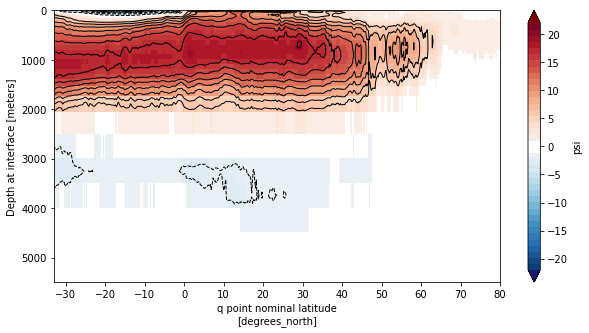

In [35]:
fig, ax = plt.subplots(figsize=(10,5))
amoc_z_mean.plot(ax=ax,x='yq', y='z_i',yincrease=False, vmin=-22, vmax=22, cmap=cmap, levels=41, extend='both',
                 cbar_kwargs={'ticks': np.arange(-20,25,5)})
amoc_z_mean.plot.contour(ax=ax, x='yq', y='z_i', yincrease=False, 
                         levels=np.concatenate([np.arange(-20,0,2),np.arange(5,22,2)]), colors='k', linewidths=1)
ax.set_xlim((-33,80))
ax.set_xticks(np.arange(-30,90,10))
ax.set_ylim((5500,0))

plt.savefig('/home/jtesdal/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()